In [ ]:
%reload_ext autoreload

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.examples.prob_dists import *
from quantum_tools.utilities.job_queuer_async import JobContext
from quantum_tools.utilities.constants import *
from quantum_tools.config import *
from quantum_tools.visualization.hypergraph import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.visualization.triangle_plot import *
from quantum_tools.hypergraph.hypergraph_transversals import *
from quantum_tools.hypergraph.inequalities import *
from quantum_tools.contexts.measurement import *
from quantum_tools.contexts.quantum_caller import *
# from quantum_tools.inflation.positive_linear_solve import *
from quantum_tools.contexts.state import *
from quantum_tools.contexts.quantum_context import *
from scipy import sparse, optimize
import numpy as np
from quantum_tools.rmt import rmt
import math
from scipy import io
from cmath import exp
import os
from itertools import product, combinations, permutations, combinations_with_replacement
from functools import reduce
from operator import mul, itemgetter

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False

## Init Config

In [4]:
USE_ORBITS = False
LOOK_FOR_SYMMETRIC_INEQUALITIES = True
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))

dimensions = 2
triangle_permutation = utils.get_triangle_permutation(dimensions)

symbolic_context = symbolic_contexts.ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)
b_string = get_preinjectablesets_latex(infl_rvc, preinjectable_sets)
duplication_map = get_duplication_map(b_string)

symbolic_context

SymbolicContext(preinjectable_sets=[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']], [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']], [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']], [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']], [['A1'], ['B3'], ['C4']], [['A1'], ['B4'], ['C2']], [['A2'], ['B1'], ['C4']], [['A2'], ['B2'], ['C2']], [['A3'], ['B3'], ['C3']], [['A3'], ['B4'], ['C1']], [['A4'], ['B1'], ['C3']], [['A4'], ['B2'], ['C1']]], outcomes=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

## Symmetry With Respect To Exchange Of Parties Under Deflation

There are $3$ tiers of symmetries to consider when doing inflation.

1. Exchange of parties within the **pre-injectable sets** and their deflation.
1. Exchange of parties within the **injectable sets** and their deflation.
1. Algebraic equivalence of the **entire inequality** under the exchange of parties. Exchange within injectable sets and between preinjectable sets.

(1) is the strongest, but is only sufficient for (3). (2) is necessary for (3) but not sufficient.

$P(A=0, B=1)P(B=2, C=3) \rightarrow_{A \leftrightarrow C} P(C=0, B=1)P(B=2, A=3)$

In [5]:
# Generate the group
def rvc_exchange_group(rvc):
    within_face_permutations = []
    k = 0
    for rv in rvc:
        num_outcomes = rv.num_outcomes
        within_face_permutations.append(permutations(range(k, num_outcomes+k)))
        k += num_outcomes
    result = []
    for face_permutation in product(*within_face_permutations):
        for i in permutations(face_permutation):
            result.append(list(utils.flatten(i)))
    return result

In [38]:
# pprint(rvc_exchange_group(rvc)[:100])

In [41]:
exchange_group = rvc_exchange_group(rvc)
exchange_group = [itemgetter(*i) for i in exchange_group]
jos_sc = generate_joint_outcomes_for_sc(infl_rvc, preinjectable_sets)
num_jos_sc = num_sc_joint_outcome(infl_rvc, preinjectable_sets)
mblbt = build_mblbt(infl_rvc, preinjectable_sets, just_preinjectable=True)
exchange_orbits = get_orbits(exchange_group, jos_sc, indexof=mblbt.get_val, num_elems=num_jos_sc)

ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))


In [61]:
exchange_orbit_address = np.zeros(sum([len(eo) for eo in exchange_orbits]), dtype='int32')
for i, eo in enumerate(exchange_orbits):
    for ant in eo:
        exchange_orbit_address[ant] = i

In [70]:
exchange_matrix = get_sum_description(exchange_orbits, sparse.csr_matrix)

In [79]:
np.sort(exchange_orbits[exchange_orbit_address[563]])

array([  563,   572,   707,   716,   803,   812,   818,   824,   899,   908,   962,   968,  2099,  2108,  2243,  2252,
        3107,  3116,  3122,  3128,  3203,  3212,  3266,  3272,  4659,  4668,  4803,  4812,  4899,  4908,  4914,  4920,
        4995,  5004,  5058,  5064,  6195,  6204,  6339,  6348,  7203,  7212,  7218,  7224,  7299,  7308,  7362,  7368,
        8755,  8764,  8899,  8908,  8995,  9004,  9010,  9016,  9091,  9100,  9154,  9160, 10291, 10300, 10435, 10444,
       11299, 11308, 11314, 11320, 11395, 11404, 11458, 11464, 12851, 12860, 12995, 13004, 13091, 13100, 13106, 13112,
       13187, 13196, 13250, 13256, 14387, 14396, 14531, 14540, 15395, 15404, 15410, 15416, 15491, 15500, 15554, 15560])

In [113]:
Latex(*b_string[np.sort(np.where(symmetrizingmatrix[2] != 0.0)[0])])

In [74]:
utils.save_sparse(utils.temp_dir('party_and_outcome_exchange_matrix.mtx'), get_sum_description(exchange_orbits, sparse.csr_matrix))

In [69]:
Latex(*b_string[exchange_orbits[exchange_orbit_address[563]]])

In [88]:
weak_exchange_orbits = []
weak_exchange_orbits_seen = np.zeros(len(b_string), dtype='bool')
injectable_outcomes = list(product(range(4), range(4), range(4)))
injectable_group_lookup = defaultdict(list)
injectable_outcomes_seen = np.zeros(len(injectable_outcomes), dtype='bool')
injectable_actions = [itemgetter(*i) for i in permutations(range(3))]
for i, outcome in enumerate(injectable_outcomes):
    if injectable_outcomes_seen[i]:
        continue
    else:
        for action in injectable_actions:
            action(outcome)

get_orbits(injectable_actions, injectable_outcomes, )
quadratic_injectable_outcomes = product(injectable_outcomes, i)
for ant in range(len(b_string)):
    if not weak_exchange_orbits_seen[ant]:
    for i in :
        print(i)
    
# permutations(range(3))

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 3, 0)
(0, 3, 1)
(0, 3, 2)
(0, 3, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 3, 0)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(2, 2, 3)
(2, 3, 0)
(2, 3, 1)
(2, 3, 2)
(2, 3, 3)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
(3, 2, 3)
(3, 3, 0)
(3, 3, 1)
(3, 3, 2)
(3, 3, 3)


In [53]:
pprint(sorted(exchange_orbits[14]))
Latex(*b_string[exchange_orbits[14]])

[22,
 97,
 262,
 352,
 1537,
 1552,
 25,
 145,
 265,
 400,
 2305,
 2320,
 4118,
 4193,
 12550,
 8544,
 13825,
 9744,
 4121,
 4241,
 12553,
 8592,
 14593,
 10512,
 4166,
 4196,
 13318,
 9312,
 13828,
 9792,
 4169,
 4244,
 13321,
 9360,
 14596,
 10560,
 70,
 100,
 1030,
 1120,
 1540,
 1600,
 73,
 148,
 1033,
 1168,
 2308,
 2368,
 12310,
 8289,
 4358,
 4448,
 9729,
 13840,
 12313,
 8337,
 4361,
 4496,
 10497,
 14608,
 8214,
 12385,
 8454,
 12640,
 5633,
 5648,
 8217,
 12433,
 8457,
 12688,
 6401,
 6416,
 8262,
 12388,
 9222,
 13408,
 5636,
 5696,
 8265,
 12436,
 9225,
 13456,
 6404,
 6464,
 12358,
 8292,
 5126,
 5216,
 9732,
 13888,
 12361,
 8340,
 5129,
 5264,
 10500,
 14656]


In [7]:
b_string

array(['P(A_0B_0C_0)P(A_0B_0C_0)', 'P(A_0B_0C_0)P(A_0B_0C_1)', 'P(A_0B_0C_0)P(A_0B_0C_2)', ..., 'P(A_3)P(B_3)P(C_1)',
       'P(A_3)P(B_3)P(C_2)', 'P(A_3)P(B_3)P(C_3)'], 
      dtype='<U24')

## Finalized Symmetries

In [6]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(symbolic_contexts.ABC_444_444)
# get_contraction(infl_rvc, symbolic_contexts.ABC_444_444.preinjectable_sets)

16896 16777216
ShiftedBase(shift=0, base=(4194304, 1048576, 262144, 65536, 16384, 4096, 1024, 256, 64, 16, 4, 1))
ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))
Found 450 row_orbits.
Found 358120 col_o

In [7]:
def orbit_from_ant(orbit_matrix, ant):
    return orbit_matrix[np.where((orbit_matrix[:, ant].indptr[1:]- orbit_matrix[:, ant].indptr[:-1]) != 0)[0][0], :].indices

In [8]:
eliesymmetrizingmatrix = sparse.csr_matrix(np.loadtxt(utils.temp_dir('symmetrizingmatrix.csv'), delimiter=','))
orbit_matrix = row_sum

In [9]:
def orbitize_w(orbit_matrix, w):
    orbit_matrix = sparse.csr_matrix(orbit_matrix)
    orbit_sizes = np.array(orbit_matrix.sum(axis=1)).flatten()
    max_orbit = np.max(orbit_sizes)
    orbit_duplication_count = np.divide(max_orbit, orbit_sizes)
    orbit_indices = [orbit_matrix[i, :].indices for i in range(orbit_matrix.shape[0])]
    orbit_w = np.zeros(len(w))
    for w_i, w_val in enumerate(w):
        if w_val == 0:
            continue
        orbit_col = orbit_matrix[:, w_i]
        orbit_indx = np.where((orbit_col.indptr[1:] - orbit_col.indptr[:-1]) != 0)[0][0]
        orbit_val = w_val * orbit_duplication_count[orbit_indx]
        orbit_w[orbit_indices[orbit_indx]] = orbit_val
    return orbit_w

In [153]:
orbitize_w(orbit_matrix, found[0]['w'].flatten())

-2.0

In [14]:
list(utils.unique_everseen(np.array(row_sum.sum(axis=1)).flatten()))

[4, 24, 12, 48, 8]

In [27]:
row_orbits_diff = (row_sum != symmetrizingmatrix)
np.where((row_orbits_diff.indptr[1:] - row_orbits_diff.indptr[:-1]) != 0)[0]

array([338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448])

In [41]:
Latex(*b_string[row_sum[30, :].indices])

In [10]:
if USE_ORBITS:
    target_A = contracted_A.copy()
    target_A.data.fill(1) # Unitize
    orbit_contractor = row_sum
    def hg_remove(ant):
        return [ant]
else:
    target_A = A
    orbit_contractor = None

In [11]:
target_A = sparse.csr_matrix(target_A) # Best format for computing the hypergraphs
target_A_format_cache = { # Even better
    'csc': sparse.csc_matrix(target_A),
    'csr': sparse.csr_matrix(target_A),
}

In [862]:
preinjectable_sets

[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
 [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
 [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
 [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
 [['A1'], ['B3'], ['C4']],
 [['A1'], ['B4'], ['C2']],
 [['A2'], ['B1'], ['C4']],
 [['A2'], ['B2'], ['C2']],
 [['A3'], ['B3'], ['C3']],
 [['A3'], ['B4'], ['C1']],
 [['A4'], ['B1'], ['C3']],
 [['A4'], ['B2'], ['C1']]]

# Optimization Pipeline

1. Params ✓
1. Measurement Operators, States ✓
1. QuantumContext ✓
1. Probability Distribution ✓
1. Marginal Factorized Context Vector ✓
1. Row Sum Contraction ✓
1. Hypergraph Selection Contraction ✓
1. Antecedent, Consequent Selection ✓
1. Inequality Evaluation ✓

## Finding The Party Invariant Deflated Terms

In [12]:
def get_party_symmetric_deflated_terms():
    num_outcomes = 4
    string_invariants = []
    top = 'P(A_{0}B_{0}C_{0})P(A_{1}B_{1}C_{1})'
    bottom = 'P(A_{0})P(B_{0})P(C_{0})'
    for i, j in product(range(num_outcomes), range(num_outcomes)):
        string_invariants.append(top.format(i, j))
    
    for i in range(num_outcomes):
        string_invariants.append(bottom.format(i))
    
    party_invariant_terms = [duplication_map[si] for si in string_invariants]
    
    party_invariant_terms = sorted(utils.flatten(party_invariant_terms))
        
    return party_invariant_terms
    
party_invariant_terms = get_party_symmetric_deflated_terms()

## Iterate Over Found Transversal Indices

In [13]:
def ifi(fts):
    for i in range(fts.shape[1]):
        yield fts.indices[fts.indptr[i]:fts.indptr[i+1]]

In [14]:
def cluster_pd(pd, bucket_resolution=0.01):
    support = pd._support.copy()
    buckets = np.arange(0, 1, bucket_resolution)
    for i in range(len(buckets) - 1):
        in_bucket = np.bitwise_and(buckets[i] <= support, support < buckets[i+1])
#         print(b)
        val_of_participants = support[np.where(in_bucket)]
        if len(val_of_participants) > 0:
            support[in_bucket] = 0 if buckets[i] == 0 else round(np.mean(val_of_participants), 5)
    support /= round(np.sum(support), 5)
    return ProbDist(pd._rvc, support)

def trim_pd(pd, trim=1e-6):
    support = pd._support.copy()
    support[support < trim] = 0.0
    support /= np.sum(support)
    
    return ProbDist(pd._rvc, support)

## Weighted Filtering

In [15]:
def filter_against_target(b, antecedent, hg_rows):
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # The marginals in the space of the hypergraph (values on nodes)
    
    def target_filter(wt_indices):
        """
        wt: The working transversal to consider filtering out
        """
        consequent_values = marginals_hg_space[wt_indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
#         print(target)
        return target > -1e-6

    return target_filter

## Identifying the Degenerate Antecedents Under Deflation

In [860]:
def determine_degenerate_antecedents_under_deflation():
    feasible_ant = []
    infeasible_ant = []
    for a in range(A.shape[0]):
        print(a, end='\r')
        hg_rows, hg, hg_cols = sort_hg(*hyper_graph(target_A_format_cache, a, remove=hg_remove(a)))
        if hg[:, 0].sum(axis=0)[0,0] > 0:
#         if transversals_exist(hg):
            feasible_ant.append(a)
        else:
            infeasible_ant.append(a)
    return np.array(feasible_ant), np.array(infeasible_ant)

In [861]:
feasible_ant, infeasible_ant = determine_degenerate_antecedents_under_deflation()
print(len(feasible_ant), len(infeasible_ant))
# Outputs: 16896 0 # No infeasible transversals

16896 0


## Ineq Evaluation

In [17]:
def minimalize_fts_object(fts_object, strat=None, force=False):
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    if force or 'minimal_fts' not in fts_object:
        print("Minimalizing...")
        minimal_fts = HGT.make_minimal(hg, fts, strat)
        fts_object['minimal_fts'] = minimal_fts
        print("Done Minimalizing.")
        
def post_process_fts_object(fts_object):
    minimalize_fts_object(fts_object)
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    minimal_fts = fts_object['minimal_fts']
    if 'w' not in fts_object:
        print("Computing effective certificate...")
        w = np.zeros((target_A.shape[0], fts.shape[1]))
        for indices in ifi(minimal_fts):
            w[ant] = -1
            w[hg_rows[indices]] = 1
        fts_object['w'] = w
        print("Done computing effective certificate.")
    if 'w_sym' not in fts_object: 
        print("Computing symmetric effective certificate...")
        w = fts_object['w']
        fts_object['w_sym'] = np.hstack(tuple(orbitize_w(orbit_matrix, w[:, i].flatten())[:, np.newaxis] for i in range(w.shape[1])))
        print("Done computing symmetric effective certificate.")

def output_to_ineq(fts_object, name='w'):
    post_process_fts_object(fts_object)
    
    return Latex(*[latex_inequality(fts_object[name][:, i].flatten(), b_string) for i in range(fts_object[name].shape[1])])

def pd_to_ineq_target_from_fts_object(pd, fts_obj, multi=False, name='w'):
    if 'fts' in fts_obj:
        post_process_fts_object(fts_obj)
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        w = fts_obj[name]
        if multi:
            return [np.sum(w[:,i].flatten() * b) for i in range(w.shape[1])]
        else:
            assert(w.shape[1] == 1)
            return np.sum(w[:,0].flatten() * b)
    else:
        raise Exception("No transversals on this object.")

def algebraic_equivalence(fts):
    cms = [dict(get_coeff_map(b_string, i)) for i in ifi(fts)]
    return dict_dedup(cms)

def dict_dedup(cms):
    ucms = []
    ucms_i = []
    for cm_i, cm in enumerate(cms):
        is_dup = False
        for ucm_i, ucm in enumerate(ucms):
            if cm == ucm:
                is_dup = True
                break
        if is_dup:
            ucms_i.append(ucm_i)
        else:
            ucms_i.append(len(ucms))
            ucms.append(cm)
    return ucms, ucms_i

In [166]:
pd_to_ineq_target_from_fts_object(target_dist, found[0], name='w_sym')

Computing symmetric effective certificate...
Done computing symmetric effective certificate.


1.2817099570550419

In [ ]:
found[0]['w_sym']

In [164]:
output_to_ineq(found[0], 'w_sym').raw

Computing symmetric effective certificate...
Done computing symmetric effective certificate.


'$16P(A^0B^0C^0)P(A^2B^3C^3) + 16P(A^0B^0C^0)P(A^3B^2C^3) + 16P(A^0B^0C^0)P(A^3B^3C^2) \\leq 16P(A^0B^0C^0)P(A^0B^0C^3) + 16P(A^0B^0C^0)P(A^0B^2C^2) + 16P(A^0B^0C^0)P(A^0B^3C^0) + 16P(A^0B^0C^0)P(A^0B^3C^3) + 16P(A^0B^0C^0)P(A^1B^1C^3) + 16P(A^0B^0C^0)P(A^1B^2C^2) + 16P(A^0B^0C^0)P(A^1B^3C^1) + 16P(A^0B^0C^0)P(A^1B^3C^3) + 16P(A^0B^0C^0)P(A^2B^0C^2) + 16P(A^0B^0C^0)P(A^2B^1C^2) + 16P(A^0B^0C^0)P(A^2B^2C^0) + 16P(A^0B^0C^0)P(A^2B^2C^1) + 16P(A^0B^0C^0)P(A^2B^2C^3) + 16P(A^0B^0C^0)P(A^2B^3C^2) + 16P(A^0B^0C^0)P(A^3B^0C^0) + 16P(A^0B^0C^0)P(A^3B^0C^3) + 16P(A^0B^0C^0)P(A^3B^1C^1) + 16P(A^0B^0C^0)P(A^3B^1C^3) + 16P(A^0B^0C^0)P(A^3B^2C^2) + 16P(A^0B^0C^0)P(A^3B^3C^0) + 16P(A^0B^0C^0)P(A^3B^3C^1) + 16P(A^0B^0C^1)P(A^2B^2C^0) + 16P(A^0B^0C^1)P(A^2B^2C^1) + 16P(A^0B^0C^1)P(A^2B^2C^2) + 16P(A^0B^0C^1)P(A^2B^2C^3) + 16P(A^0B^0C^1)P(A^3B^3C^0) + 16P(A^0B^0C^1)P(A^3B^3C^1) + 16P(A^0B^0C^1)P(A^3B^3C^2) + 16P(A^0B^0C^2)P(A^0B^2C^0) + 16P(A^0B^0C^2)P(A^1B^1C^0) + 16P(A^0B^0C^2)P(A^2B^0C^0) + 16P(A^0B

## Actually Compute Transversals

In [ ]:
# Do the transversal
def do_transversal(fts, batch_size, num_batches):
    antecedent = 563
    top_antecedents = list(range(16384))
    bottom_antecedents = list(range(16384, 16384 + 512))
    hg_rows, hg, hg_cols = sort_hg(*hyper_graph(target_A_format_cache, antecedent, remove=hg_remove(antecedent)))
    
    starting_size = 0 if fts is None else fts.shape[1]
    ending_size = starting_size + batch_size * num_batches
    i = starting_size
    while i < ending_size:
#         print('i is currently:', i)
        batch_strat = TransversalStrat(
            search_type='depth',
#             breadth_cap=5,
#             filter_out=filter_against_target(fritz_dist, g_antecedent, g_hg_rows),
            find_up_to= i + batch_size,
            node_brancher={
                'name': 'greedy',
                'max': 1,
#                 'shuffle' : True,
            }
        )
    
        fts = find_transversals(hg, strat=batch_strat, log={'wt':False, 'ft':False})
        if fts is None:
            break
        i = fts.shape[1]

    ret_obj = {
        'antecedent':antecedent,
        'fts':fts,
        'hg_rows':hg_rows,
        'hg':hg,
        'hg_cols':hg_cols,
    }
    return ret_obj

noweighted_fts_obj = do_transversal(None, 1, 1)

minimalize_fts_object(noweighted_fts_obj)
noweighted_fts_obj

In [ ]:
output_to_ineq(noweighted_fts_obj)

## Trying Out Custom Distributions

In [ ]:
def gen_pair_wise_entangled_states(evs, phis):
    states = []
    for phi in phis:
        for ortho_set in evs:
            for psi1, psi2 in permutations(ortho_set, 2):
                    states.append((psi1 + exp(1j * phi) * psi2)/sqrt2)
    return states

In [ ]:
def qubit_phase(gamma):
    return 1/sqrt2 * np.array([
            [              1,                         1],
            [exp(1j * gamma), exp(1j * (gamma - np.pi))],
        ])

In [ ]:
def rotation(x,y,z):
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    Rx = np.array([
        [cx,sx,0,0],
        [-sx,cx,0,0],
        [0,0,1,0],
        [0,0,0,1],
    ])
    Ry = np.array([
        [1,0,0,0],
        [0,cx,sx,0],
        [0,-sx,cx,0],
        [0,0,0,1],
    ])
    Rz = np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,cx,sx],
        [0,0,-sx,cx],
    ])
    return Rx, Ry, Rz

In [ ]:
pauli_combiners = [
    lambda x, y: x,
    lambda x, y: y,
    lambda x, y: (x+y),
    lambda x, y: (x-y),
#     lambda x, y: (x+1j*y),
#     lambda x, y: (x-1j*y),
]

In [ ]:
pauli = rmt.pauli(4) # Set of 4x4 generalized paulis (16)
# pauli = [utils.tensor(np.eye(2), qubit_phase(pi/4)).dot(i) for i in pauli]
pauli_ev = [] # The 4 eigenvectors for each of the paulis (4 x 16)
pauli_measure = [] # The corresponding measurement tuple for the paulis (4 x 16)
pi = np.pi
for M1, M2 in combinations(pauli + [np.zeros((4,4))], 2):
    for combiner in pauli_combiners:
        M = combiner(M1, M2)
        eig_vals, eig_vecs = np.linalg.eig(M)
        eig_vecs = [eig_vecs[:, i] for i in range(M.shape[0])]
        pauli_ev.append(eig_vecs)
        pvms = [utils.ket_to_dm(ev) for ev in eig_vecs]
        pauli_measure.append(pvms)

pwep = gen_pair_wise_entangled_states(pauli_ev, [0, pi, pi/2, pi/4, pi/3])
pwep_dm = list(map(utils.ket_to_dm, pwep))

In [ ]:
pauli = rmt.pauli(2) # Set of 4x4 generalized paulis (16)
# pauli = [utils.tensor(np.eye(2), qubit_phase(pi/4)).dot(i) for i in pauli]
pauli_ev = [] # The 4 eigenvectors for each of the paulis (4 x 16)
pauli_measure = [] # The corresponding measurement tuple for the paulis (4 x 16)
pi = np.pi
for p1, p2 in combinations(combinations(pauli, 2), 2):
    for c1, c2 in combinations(pauli_combiners, 2):
        M = utils.tensor(c1(p1[0], p1[1]), c2(p2[0], p2[1]))
        eig_vals, eig_vecs = np.linalg.eig(M)
        eig_vecs = [eig_vecs[:, i] for i in range(M.shape[0])]
        pauli_ev.append(eig_vecs)
        pvms = [utils.ket_to_dm(ev) for ev in eig_vecs]
        pauli_measure.append(pvms)

pwep = gen_pair_wise_entangled_states(pauli_ev, [0, pi, pi/2, pi/4, pi/3])
pwep_dm = list(map(utils.ket_to_dm, pwep))

In [ ]:
m = [i.flatten() for i in get_measurement_collection()[2]][3] 
print(m)
string_list = []
for i, p_set in enumerate(pauli_ev):
    for j, p in enumerate(p_set):
        if np.allclose(p, m):
            string_list.append((i, j))
print(string_list)

In [ ]:
def get_measurement_collection():

    ei = utils.ei
    pi = np.pi
    i = 1j
    # Eigenvectors of sigma_x
    e_x_0 = qubit_phase(0).dot(qb0)
    e_x_1 = qubit_phase(0).dot(qb1)
    # Eigenvectors of sigma_y
    e_y_0 = qubit_phase(pi/2).dot(qb0)
    e_y_1 = qubit_phase(pi/2).dot(qb1)
    # Eigenvectors of -(sigma_y + sigma_x)/sqrt2
    e_yx_0 = qubit_phase(pi/4).dot(qb0)
    e_yx_1 = qubit_phase(pi/4).dot(qb1)
    # Eigenvectors of (sigma_y - sigma_x)/sqrt2
    e_xy_0 = qubit_phase(-pi/4).dot(qb0)
    e_xy_1 = qubit_phase(-pi/4).dot(qb1)
    
    measurements = [
        [
            utils.tensor(qb0, qb1),
            utils.tensor(qb0, qb0),
            utils.tensor(qb1, qb1),
            utils.tensor(qb1, qb0),
        ],
        [
            utils.tensor(qb1, e_y_0),
            utils.tensor(qb1, e_y_1),
            utils.tensor(qb0, e_x_1),
            utils.tensor(qb0, e_x_0),
        ],
        [
            utils.tensor(e_xy_0, qb0),
            utils.tensor(e_xy_1, qb0),
            utils.tensor(e_yx_0, qb1),
            utils.tensor(e_yx_1, qb1),
        ],
        [
            utils.tensor(e_xy_0, e_y_0),
            utils.tensor(e_xy_0, e_y_1),
            utils.tensor(e_xy_1, e_x_1),
            utils.tensor(e_xy_1, e_x_0),
        ],
    ]
    return measurements

def custom_q_distro():
#     measurements = get_measurement_collection()
#     measurements = [[utils.ket_to_dm(i) for i in m] for m in measurements]
#     A = Measurement(measurements[0])
#     B = Measurement(measurements[0])
#     C = Measurement(measurements[0])
    Rx, Ry, Rz = rotation(pi/12, pi/12, pi/12)
    
    A = Measurement([Rx.T.dot(p).dot(Rx) for p in pauli_measure[0]])
    B = Measurement([Ry.T.dot(p).dot(Ry) for p in pauli_measure[0]])
    C = Measurement([Rz.T.dot(p).dot(Rz) for p in pauli_measure[0]])
    
#     rhoAB = State.Strats.Deterministic.mebs(0)
#     rhoBC = State.Strats.Deterministic.mebs(0)
#     rhoAC = State.Strats.Deterministic.mebs(0)

    
    rhoAB = State(pwep_dm[9])
    rhoBC = State(pwep_dm[9])
    rhoAC = State(pwep_dm[9])

    
    qc = QuantumContext(
        random_variables=rvc,
        measurements=(A,B,C),
        states=(rhoAB,rhoBC,rhoAC),
        permutation=triangle_permutation,
    )
#     print(qc)
#     print([isinstance(m, ProjectiveMeasurement) for m in qc.measurements])
    pd = QuantumProbDist(qc)

    return pd
custom_dist = custom_q_distro()

In [ ]:
triangle_plot(custom_dist)

In [ ]:
custom_support = np.array(
[[[ 0,  0,  0,  1 ],
  [ 0,  0,  1,  0 ],
  [ 0,  1,  0,  0 ],
  [ 1,  0,  0,  0 ],],

 [[ 0,  0,  0,  0 ],
  [ 0,  0,  0,  1 ],
  [ 0,  0,  1,  0 ],
  [ 0,  1,  0,  0 ],],

 [[ 0,  0,  0,  0 ],
  [ 0,  0,  0,  0 ],
  [ 0,  0,  0,  1 ],
  [ 0,  0,  1,  0 ],],

 [[ 0,  0,  0,  0 ],
  [ 0,  0,  0,  0 ],
  [ 0,  0,  0,  0 ],
  [ 0,  0,  0,  1 ],]])
custom_support = custom_support.astype('float64')
custom_support /= np.sum(custom_support)
custom_dist = ProbDist(rvc, custom_support)

In [ ]:
custom_dist = cluster_pd(get_qcontext(qpc), bucket_factor=0.15)

In [ ]:
QuantumOptimizer.ipynb

In [ ]:
custom_dist = ProbDist(rvc, 1/3 *(fritz_support + fritz_support.transpose((1,2,0)) + fritz_support.transpose((2,0,1))))

In [ ]:
fritz_support = fritz(rvc)._support
triangle_plot(ProbDist(rvc, 1/3 *(fritz_support.transpose((0,1,2)) + fritz_support.transpose((1,2,0)) + fritz_support.transpose((2,0,1)))))

In [ ]:
cd = np.zeros((4,4,4))
cd[0, 0, 0] = 0.25
cd[0, 0, 3] = 0.125
cd[0, 3, 0] = 0.125
# cd[1, 0, 3] = 0.075
# cd[1, 3, 0] = 0.075
cd[2, 0, 3] = 0.125
cd[2, 3, 0] = 0.125
cd[2, 3, 3] = 0.25
# cd[3, 0, 3] = 0.075
# cd[3, 3, 0] = 0.075
cd /= np.sum(cd)
custom_dist = ProbDist(rvc, cd)  

In [878]:
cd = np.zeros((4,4,4))
# cd[0, 0, 0] = 1

cd[0, 1, 2] = 1
cd[2, 0, 1] = 1
cd[1, 2, 0] = 1

cd[1, 2, 3] = 1
cd[3, 1, 2] = 1
cd[2, 3, 1] = 1

cd[2, 3, 0] = 1
cd[0, 2, 3] = 1
cd[3, 0, 2] = 1

cd[3, 0, 1] = 1
cd[1, 3, 0] = 1
cd[0, 1, 3] = 1

# cd[3, 3, 3] = 1
cd /= np.sum(cd)
custom_dist = ProbDist(rvc, cd)

<IPython.core.display.Javascript object>


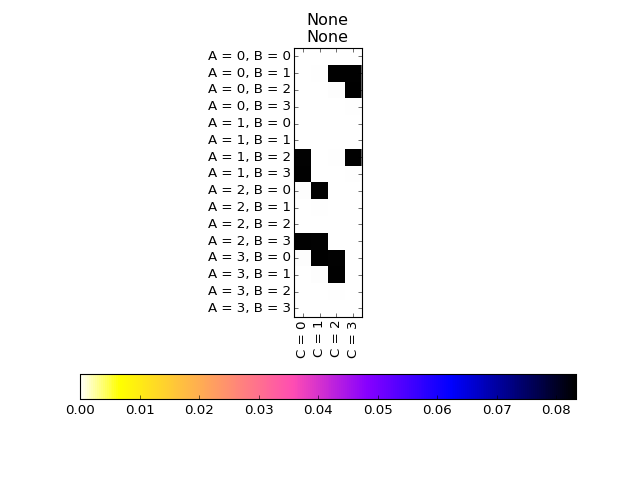

In [879]:
triangle_plot(custom_dist)

In [ ]:
triangle_plot(cluster_pd(cached_custom_dist, 0.025))

In [17]:
print(cluster_pd(custom_dist, 0.001))

=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
16 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.11884
[0, 0, 1] -> 0.00616
[0, 1, 0] -> 0.00616
[0, 1, 1] -> 0.11884
[1, 0, 2] -> 0.08956
[1, 0, 3] -> 0.03544
[1, 1, 2] -> 0.03544
[1, 1, 3] -> 0.08956
[2, 2, 0] -> 0.08956
[2, 2, 1] -> 0.03544
[2, 3, 0] -> 0.03544
[2, 3, 1] -> 0.08956
[3, 2, 2] -> 0.00616
[3, 2, 3] -> 0.11884
[3, 3, 2] -> 0.11884
[3, 3, 3] -> 0.00616


<IPython.core.display.Javascript object>


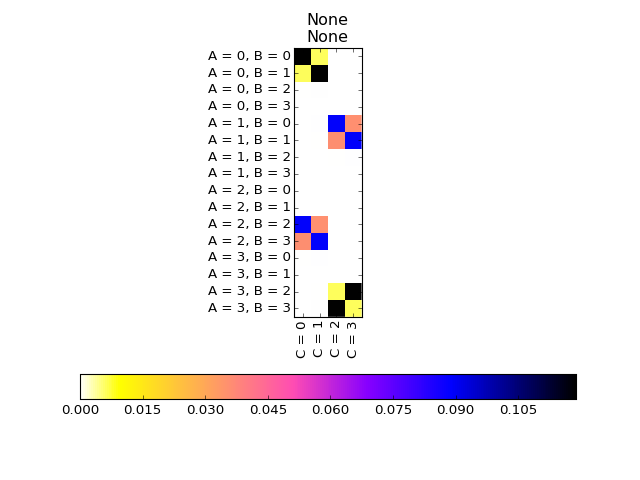

In [16]:
triangle_plot(cluster_pd(custom_dist, 0.001))

In [6]:
qc = StateRestrictedQuantumCaller(None, rvc, triangle_permutation)
custom_dist = qc.context(np.loadtxt(utils.temp_dir('possibly_new_dist.csv')))

In [7]:
print(custom_dist)

=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
64 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.11884039478726605
[0, 0, 1] -> 0.0061596052126857625
[0, 1, 0] -> 0.006159605212691386
[0, 1, 1] -> 0.11884039478727558
[1, 0, 2] -> 0.08955600890549756
[1, 0, 3] -> 0.03544399109441799
[1, 1, 2] -> 0.0354439910944285
[1, 1, 3] -> 0.08955600890552431
[2, 2, 0] -> 0.08955517011121843
[2, 2, 1] -> 0.035444829888732585
[2, 3, 0] -> 0.035444829888726166
[2, 3, 1] -> 0.08955517011120068
[3, 2, 2] -> 0.006159516617565557
[3, 2, 3] -> 0.1188404833823946
[3, 3, 2] -> 0.11884048338238834
[3, 3, 3] -> 0.006159516617570057


## Testing Against Multiple Antecedents

In [18]:
target_dist = fritz(rvc)
target_b = get_b(target_dist, preinjectable_sets, orbit_contractor) # The values corresponding to the preinjectable marginals
positive_antecdents = np.where(target_b >= 1e-6)[0]
bottom_antecedents = positive_antecdents[positive_antecdents >= 4*(4**(2*3))]
top_antecedents = positive_antecdents[positive_antecdents < 4*(4**(2*3))]

In [19]:
print(len(top_antecedents))
print(len(bottom_antecedents))

1024
512


In [22]:
from quantum_tools.utilities.job_queuer_async import JobContext
import sys

# antecedents = []
# antecedents = list(range(4))
# antecedents = [16384, 16385, 16386, 16387]
# antecedents = [16384]

pwt_jc = []

def get_aprint(antecedent):
    def _aprint(*args):
        msg = '{:<5} :: '.format(antecedent) + ' '.join(args) + os.linesep
        sys.stdout.write(msg)
        sys.stdout.flush()
    return _aprint

def parallel_weighted_transversals(antecedents):
    target_args = [[a] for a in antecedents]
    jc = JobContext(weighted_transversal, target_args)
    pwt_jc.append(jc)
    jc.evaluate()
    return jc.target_results

def get_removal(antecedent):
#     duplicate_antecedents = duplication_map[b_string[antecedent]]
    remove_list = []
    larger_positive_consequents = np.where(target_b >= target_b[antecedent])[0]
    remove_list.append(larger_positive_consequents)
    
    if LOOK_FOR_SYMMETRIC_INEQUALITIES:
        orbit_elements = orbit_from_ant(orbit_matrix, antecedent)
        remove_list.append(orbit_elements)
        
    remove_stack = np.hstack(remove_list)
    return remove_stack
#     aprint('Number of duplicate antecdents: {}'.format(len(duplicate_antecedents)))  
#     aprint('Number of larger possible consequents: {}'.format(len(larger_positive_consequents)))
#     remove = np.append(duplicate_antecedents, larger_positive_consequents)
    

def weighted_transversal(antecedent, find_up_to=1):
    aprint = get_aprint(antecedent)
    aprint('Antecedent: {}'.format(antecedent))
    ret_obj = {'antecedent': antecedent}
    remove = get_removal(antecedent)
    aprint('Number of nodes removed (including ant) {}'.format(len(remove)))
    aprint('Building Hypergraph...')
    hg_rows, hg, hg_cols = hyper_graph(target_A_format_cache, antecedent, remove=remove)
    if not transversals_exist(hg):
        aprint('No transversals to begin with.')
        return ret_obj
    aprint('Sorting nodes by target weight...')
    aprint('Sorting edges by cardinality...')
    hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
    aprint('hg.shape: {}'.format(hg.shape))
    aprint('density(hg): {}'.format(utils.sparse_density(hg)))
    starting_transversal = (target_b[hg_rows] == 0).astype(int)
    aprint('grabbing {} nodes greedily'.format(np.sum(starting_transversal)))
#     === Node necessities is an speed up but takes a long time to compute ===
#     node_necessities = HGT.get_node_necessity(hg, get_full_transversal(len(hg_rows)))
#     aprint('{} necessary nodes'.format(len(node_necessities.necessary)))
#     for nn in node_necessities.necessary:
#         starting_transversal[nn] = 1
    aprint('starting transversal has {} nodes'.format(np.sum(starting_transversal)))
    strat = TransversalStrat(
        search_type='depth',
        # breadth_cap=5,
        filter_out=filter_against_target(target_b, antecedent, hg_rows),
        starting_transversal=starting_transversal[:, np.newaxis],
        discontinue_branch_on_filter=True,
        find_up_to=find_up_to,
        node_brancher={
#             'name': 'greedy',
#             'max': 2
#             'shuffle' : True,
        }
    )
    fts = find_transversals(hg, strat=strat, log={'wt':False, 'ft':False, 'print':aprint})
    aprint('repr(fts): {}'.format(repr(fts)))
    if fts is not None:
        ret_obj.update({
            'fts':fts,
            'hg_rows':hg_rows,
            'hg':hg,
            'hg_cols':hg_cols,
            'remove':remove,
        })
    return ret_obj

P(A^0B^0C^0)P(A^2B^3C^3)
719 used nodes
36 unused nodes
18 unused empty nodes
18 unused non-empty nodes
Hypergraph reduced from (755, 4096) to (18, 16)


<IPython.core.display.Javascript object>


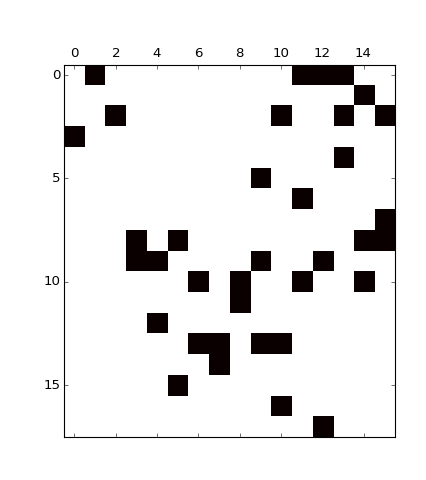

In [23]:
antecedent = 563
print(b_string[antecedent])
hg_rows, hg, hg_cols = hyper_graph(target_A_format_cache, antecedent, remove=get_removal(antecedent))
hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
starting_transversal = sparse.csc_matrix((target_b[hg_rows] == 0).astype(int)[:, np.newaxis])

super_reduced = perform_starting_transversal_reduction(hg, starting_transversal)
unused_nonempty_H, used_nodes, unused_nodes, unused_empty_nodes, unused_nonempty_nodes = super_reduced

antecedent_weight = target_b[antecedent]
node_weights= target_b[hg_rows][unused_nodes][unused_nonempty_nodes]

if np.count_nonzero(unused_nonempty_nodes) > 0:
    plt.matshow(unused_nonempty_H.todense(), cmap='hot_r')

In [ ]:
# print(np.sum(np.sort(np.array(unused_nonempty_H.sum(axis=1)).flatten())[::-1][:32]))
# print(np.sum(node_weights[:100]))
# print(antecedent_weight)
print(hg.sum(axis=0))

In [ ]:
antecedent_weight

In [ ]:
node_weights

In [77]:
fts_obj = weighted_transversal(563, 1)

563   :: Antecedent: 563
563   :: Number of nodes removed (including ant) 792
563   :: Building Hypergraph...
563   :: Sorting nodes by target weight...
563   :: Sorting edges by cardinality...
563   :: hg.shape: (755, 4096)
563   :: density(hg): 0.00390625
563   :: grabbing 719 nodes greedily
563   :: starting transversal has 719 nodes
563   :: 719 used nodes
563   :: 36 unused nodes
563   :: 18 unused empty nodes
563   :: 18 unused non-empty nodes
563   :: Hypergraph reduced from (755, 4096) to (18, 16)
563   :: repr(fts): <755x1 sparse matrix of type '<class 'numpy.int16'>'
	with 726 stored elements in Compressed Sparse Column format>


In [24]:
pwt = parallel_weighted_transversals(top_antecedents)

JobContext requested 15 cores.
JobContext using 15 cores.
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 0% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 1% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 2% Complete
Sub-Job Finished: 3% Complete
Sub-Job Fini

In [ ]:
len(remaining_antecedents)

In [ ]:
hit_ant = [obj['antecedent'] for obj in pwt_jc[-1].target_results]
remaining_antecedents = [i for i in remaining_antecedents if i not in hit_ant]
np.random.shuffle(remaining_antecedents)
remaining_antecedents

In [25]:
found = [obj for obj in pwt_jc[-1].target_results if 'fts' in obj]
# remaining_antecedents = [obj['antecdent'] for obj in pwt_jc[-1].target_results]
print(len(found))
found_for_antecedents = None
if len(found) > 0:
    found_for_antecedents = [f['antecedent'] for f in found]
print(found_for_antecedents)
# for f in found:
#     minimalize_fts_object(f)
for f in found:
    f['violation'] = pd_to_ineq_target_from_fts_object(target_dist, f, multi=True)
print([f['violation'] for f in found])
print([len(f['minimal_fts'].indices) for f in found])

33
[563, 803, 1891, 2252, 1651, 3212, 2524, 3484, 5014, 4668, 4908, 5756, 6611, 7299, 5996, 6339, 7571, 8899, 9091, 10131, 9939, 10300, 10620, 11308, 11628, 13004, 14236, 13196, 14707, 14044, 14387, 15395, 15715]
Minimalizing...
Done Minimalizing.
Computing effective certificate...
Done computing effective certificate.
Computing symmetric effective certificate...
Done computing symmetric effective certificate.
Minimalizing...
Done Minimalizing.
Computing effective certificate...
Done computing effective certificate.
Computing symmetric effective certificate...
Done computing symmetric effective certificate.
Minimalizing...
Done Minimalizing.
Computing effective certificate...
Done computing effective certificate.
Computing symmetric effective certificate...
Done computing symmetric effective certificate.
Minimalizing...
Done Minimalizing.
Computing effective certificate...
Done computing effective certificate.
Computing symmetric effective certificate...
Done computing symmetric effect

In [155]:
pd_to_ineq_target_from_fts_object(target_dist, found[0])

Computing symmetric effective certificate...
Done computing symmetric effective certificate.


-0.0025658369120796064

In [143]:
np.where(found[0]['w_sym'] != 0)

(array([], dtype=int64),)

In [114]:
found[0]['minimal_fts'].indices

array([119, 186, 191, 193, 195, 197, 199, 206, 207, 209, 211, 215, 217, 222, 224, 226, 230, 234, 236, 238, 242, 244,
       249, 253, 255, 258, 260, 266, 268, 270, 274, 277, 325, 331, 333, 335, 338, 340, 345, 365, 367, 371, 372, 373,
       375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 398,
       399, 400, 401, 402, 403, 405, 407, 408, 409, 411, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
       448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 459, 460, 462, 463, 464, 466, 468, 470, 471, 472, 474, 476,
       477, 478, 479, 480, 481, 482, 484, 486, 487, 488, 489, 491, 492, 493, 494, 495, 497, 499, 501, 502, 503, 504,
       505, 506, 507, 508, 509, 511, 513, 515, 516, 517, 518, 520, 521, 522, 523, 524, 526, 528, 530, 531, 532, 533,
       535, 537, 538, 539, 540, 541, 542, 544, 546, 547, 548, 54

In [27]:
output_to_ineq(found[0])

In [32]:
np.savetxt(utils.temp_dir('transversal_hardy.csv'), found[0]['w'].flatten())

## Visualizing Particular Transversals

In [ ]:
# plot_transversals(fts)

In [ ]:
# visualize_overlap(fts)

## Testing against particular distributions

In [ ]:
def triangle_test(pd, log):
    targets = pd_to_ineq_target(pd, preinjectable_sets, fts, antecedent, hg_rows, multi=True, orbit_contractor=orbit_contractor)
    if np.any(targets<0):
        print("Found {} Violations".format(log))
    else:
        print("No {} Violations".format(log))
    return pd

In [ ]:
triangle_test(uniform_qdistro(rvc, dimensions), 'Quantum')
triangle_test(uniform_discrete(rvc), 'Correlation')
triangle_test(c4_type(rvc), 'C4-type')
triangle_test(perfect_correlation(rvc), 'Perfect Correlation')
triangle_test(fritz(rvc), 'Fritz')
triangle_test(spekkens(rvc), 'Spekkens')

In [30]:
algebraic_support = np.zeros((4,4,4))
algebraic_support[0, 0, 0] = 1
algebraic_support[2, 3, 3] = 1
algebraic_support[3, 2, 3] = 1
algebraic_support[2, 3, 3] = 1
algebraic_support /= np.sum(algebraic_support)
algebraic_pd = ProbDist(rvc, algebraic_support)

pd_to_ineq_target_from_fts_object(algebraic_pd, found[0], name='w_sym')

-3.5555555555555554

## Optimizing against a Particular Inequality

In [ ]:
def how_much_CHSH_violation(pd):
    pd.update_correlation_settings({'method': 'same', 'mod': 2})
    CHSH = [
         pd.condition({'C': 0}).correlation(['A', 'B']), 
         pd.condition({'C': 1}).correlation(['A', 'B']),
         pd.condition({'C': 2}).correlation(['A', 'B']), 
         pd.condition({'C': 3}).correlation(['A', 'B']),
    ]
    terms = '<A0B0> + <A0B1> + <A1B0> - <A1B1> = {:.3} + {:.3} + {:.3} - {:.3}'.format(*CHSH)
    
    CHSH_value = sum(CHSH[0:3]) -CHSH[-1]
    print("CHSH: {} = {}".format(terms, CHSH_value))
    return "CHSH = {:.4}".format(CHSH_value)